<a href="https://colab.research.google.com/github/INT-Group-9/ColabNotebook/blob/Harry/cifa10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

#Loading
import torch
import torchvision
import torchvision.transforms as transforms

#Displaying
import matplotlib.pyplot as plt
import numpy as np

#CNN
import torch.nn as nn
import torch.nn.functional as F

#optimiser
import torch.optim as optim

Loading & Normalising CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

training_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)

testing_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Displaying samples from training set

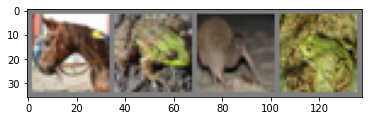

horse  frog  bird  frog


In [3]:
#This function displays an image
def imshow(img):
  img = img /2 + 0.5 #As we normalised the images during loading we need to unnormalise them.
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.show()

#Get random training images
data_iterator = iter(training_loader)
images, labels = data_iterator.next()

#display images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Defining a CNN

In [4]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    #3 input channels, 6 output channels, 5x5 square convolution kernel
    self.conv1 = nn.Conv2d(3, 6, 5)
    #6 input channels, 16 output channels, 5x5 square convolution kernel
    self.conv2 = nn.Conv2d(6, 16, 5)

    #max pooling over a 2x2 window
    self.pool = nn.MaxPool2d(2, 2)
    
    #Linear transformations
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = NeuralNet()

Defining a loss function and optimiser

In [5]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Moving to GPU

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

# net.to(device)

cuda:0


Training the network

In [7]:
for epoch in range(2): #loop over the dataset twice

  running_loss = 0.0
  for i, data in enumerate(training_loader, 0):
    inputs, labels = data

    #zero the parameter gradients
    optimiser.zero_grad()

    #forward + backward + optimise
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimiser.step()

    #print stats
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss/2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.287
[1,  4000] loss: 1.956
[1,  6000] loss: 1.722
[1,  8000] loss: 1.618
[1, 10000] loss: 1.540
[1, 12000] loss: 1.500
[2,  2000] loss: 1.424
[2,  4000] loss: 1.377
[2,  6000] loss: 1.334


KeyboardInterrupt: ignored

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Testing network on the test data

In [ ]:
data_iterator = iter(testing_loader)
images, labels = data_iterator.next()

#display images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#Loading saved model
net = NeuralNet()
net.load_state_dict(torch.load(PATH))

#Applying model to test data
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in testing_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testing_loader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))